# train a cifar10 model

## 匯入所需套件

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# Check GPU
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten,
                                     GlobalAveragePooling2D, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model

## Cifar10 資料讀入及前處理

In [4]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
test_label = y_test.flatten()

[0 1 2 3 4 5 6 7 8 9] [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]


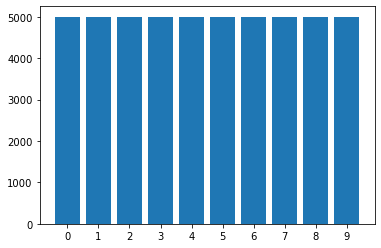

In [6]:
uniques, counts = np.unique(y_train, return_counts=True)
print(uniques, counts)

plt.bar(uniques, counts)
plt.xticks(uniques)
plt.show()

[0 1 2 3 4 5 6 7 8 9] [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


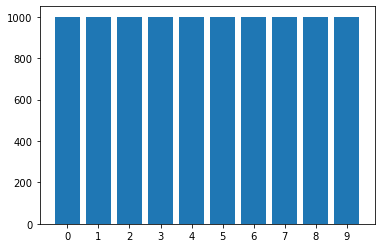

In [7]:
uniques, counts = np.unique(y_test, return_counts=True)
print(uniques, counts)

plt.bar(uniques, counts)
plt.xticks(uniques)
plt.show()

In [8]:
x_train.dtype

dtype('uint8')

In [9]:
# 記得轉成 'float32'
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# 將 features (照片影像特徵值) 標準化，可以提高模型預測的準確度，並且更快收斂
x_train /= 255  # rescaling
x_test /= 255   # rescaling

# 將訓練資料與測試資料的 label，進行 Onehot encoding 轉換
num_classes = 10
y_train = np.eye(num_classes, dtype='float32')[y_train[:, 0]]
y_test = np.eye(num_classes, dtype='float32')[y_test[:, 0]]

In [10]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 10)
y_test shape: (10000, 10)


## 模型定義

In [11]:
img_size = 32

In [12]:
model_name = 'vgg16'
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(img_size, img_size, 3))
last = base_model.get_layer('block4_pool').output
x = GlobalAveragePooling2D()(last)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=outputs)
model.trainable = True

In [13]:
learning_rate = 1e-4
optimizer = Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [14]:
def call_list_fun(model_name, img_size):
    model_dir = 'Model/'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    modelfiles = model_dir + f'/{model_name}_{img_size}.h5'
    
    model_mckp = ModelCheckpoint(modelfiles,
                                 monitor='val_accuracy',
                                 save_best_only=True)  
    learning_rate_function = ReduceLROnPlateau(monitor='val_loss', 
                                               patience=3, 
                                               verbose=1, 
                                               factor=0.5, 
                                               min_lr=0.00001)
    
    return [model_mckp, learning_rate_function]

In [15]:
batch_size = 32
num_epochs = 20
callbacks_list = call_list_fun(model_name, img_size)

In [16]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 26s 517us/sample - loss: 0.8520 - accuracy: 0.7043 - val_loss: 0.6015 - val_accuracy: 0.7958
Epoch 2/20
50000/50000 [==============================] - 23s 461us/sample - loss: 0.4957 - accuracy: 0.8294 - val_loss: 0.4920 - val_accuracy: 0.8308
Epoch 3/20
50000/50000 [==============================] - 23s 465us/sample - loss: 0.3600 - accuracy: 0.8761 - val_loss: 0.4928 - val_accuracy: 0.8377
Epoch 4/20
50000/50000 [==============================] - 23s 469us/sample - loss: 0.2539 - accuracy: 0.9123 - val_loss: 0.4451 - val_accuracy: 0.8519
Epoch 5/20
50000/50000 [==============================] - 24s 476us/sample - loss: 0.1777 - accuracy: 0.9382 - val_loss: 0.4684 - val_accuracy: 0.8545
Epoch 6/20
50000/50000 [==============================] - 23s 465us/sample - loss: 0.1273 - accuracy: 0.9549 - val_loss: 0.5236 - val_accuracy: 0.8594
Epoch 7/20
49952/50000 [====================

## 測試資料

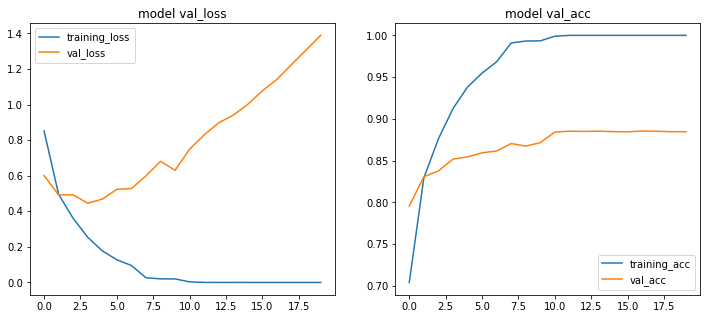

In [17]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model '+eachy)
plt.show()

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = load_model('./Model/vgg16_32.h5')
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(-1)

In [19]:
label_dict = {0:'airplane',
              1:'automobile',
              2:'bird',
              3:'cat',
              4:'deer',
              5:'dog',
              6:'frog',
              7:'horse',
              8:'ship',
              9:'truck'}

In [20]:
class_names = label_dict.values()

vgg16 Report: 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      1000
           1       0.94      0.94      0.94      1000
           2       0.87      0.85      0.86      1000
           3       0.75      0.76      0.75      1000
           4       0.87      0.90      0.89      1000
           5       0.83      0.79      0.81      1000
           6       0.90      0.92      0.91      1000
           7       0.92      0.91      0.91      1000
           8       0.95      0.94      0.94      1000
           9       0.92      0.92      0.92      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



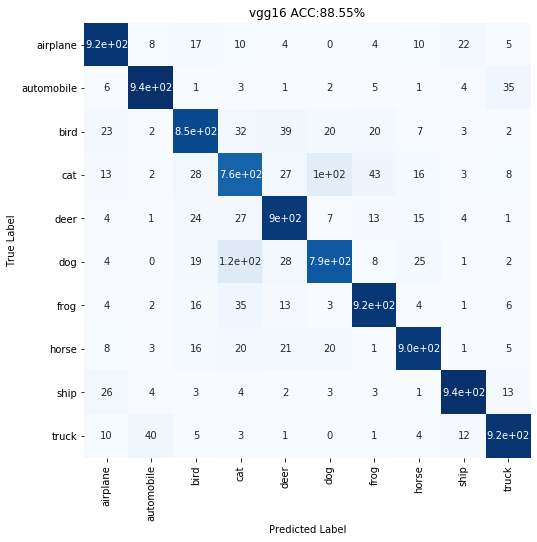

In [21]:
print(f"{model_name} Report: \n", classification_report(test_label, y_pred))
ACC = accuracy_score(test_label, y_pred)
matrix = confusion_matrix(test_label, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'{model_name} ACC:{ACC*100:.4}%')
plt.show()

# keras to onnx

In [ ]:
!pip install -q onnx onnxmltools

In [22]:
import onnx
import onnxmltools
from tensorflow.keras.models import load_model

In [27]:
keras_path = 'Model/vgg16_32.h5'
onnx_path = 'vgg16_32.onnx'
keras_model = load_model(keras_path)
onnx_model = onnxmltools.convert_keras(keras_model)

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 74 -> 37


In [28]:
onnx_model.graph.input[0].type.tensor_type.shape.dim[0].dim_value = 1
onnx_model.graph.output[0].type.tensor_type.shape.dim[0].dim_value = 1

In [29]:
onnx.checker.check_model(onnx_model)
onnx.save(onnx_model, onnx_path)